In [4]:
import os
import torch
import nbimporter
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch_geometric.data import HeteroData
from add_reverse_edges import make_undirected
from torch_geometric.nn import GENConv, HeteroConv

In [5]:
hetero_data = torch.load('data/combined_dbs_heteroGraph.pt')
print(hetero_data)

HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 7635],
    edge_attr=[7635, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 148992],
    edge_attr=[148992, 1],
  }
)


In [7]:
hetero_data = make_undirected(hetero_data)
print(hetero_data)

HeteroData(
  lncRNA={ x=[1269, 2] },
  protein={ x=[11585, 2] },
  (lncRNA, interacts, protein)={
    edge_index=[2, 7635],
    edge_attr=[7635, 4],
  },
  (protein, interacts_rev, lncRNA)={
    edge_index=[2, 7635],
    edge_attr=[7635, 4],
  },
  (protein, interacts, protein)={
    edge_index=[2, 148992],
    edge_attr=[148992, 1],
  },
  (protein, interacts_rev, protein)={
    edge_index=[2, 148992],
    edge_attr=[148992, 1],
  }
)


In [8]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATv2Conv, HeteroConv

class HeteroGNNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, metadata, hidden_channels=64, heads=2):
        super().__init__()

        # Define edge_dim manually for each edge type
        edge_dims = {
            ('lncRNA', 'interacts', 'protein'): 4,
            ('protein', 'interacts_rev', 'lncRNA'): 4,
            ('protein', 'interacts', 'protein'): 1,
            ('protein', 'interacts_rev', 'protein'): 1,
        }

        # Build GATv2Conv layers for each edge type
        self.convs = {
            edge_type: GATv2Conv(
                in_channels=in_channels,
                out_channels=out_channels,
                edge_dim=edge_dims[edge_type],
                heads=heads,
                concat=False,
                add_self_loops=False
            )
            for edge_type in metadata[1]
        }

        # Wrap with HeteroConv (which expects tuple keys)
        self.hetero_conv = HeteroConv(self.convs, aggr='sum')

        # LayerNorm for each node type
        self.norms = nn.ModuleDict({
            node_type: nn.LayerNorm(out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # Use original tuple keys directly
        out_dict = self.hetero_conv(x_dict, edge_index_dict, edge_attr_dict)

        # Normalize embeddings
        out_dict = {
            node_type: self.norms[node_type](x)
            for node_type, x in out_dict.items()
        }
        return out_dict


In [9]:
encoder = HeteroGNNEncoder(
    in_channels=2,  # لأن node features = 2
    out_channels=128,
    metadata=hetero_data.metadata(),
    hidden_channels=64,
    heads=2
)

with torch.no_grad():
    embeddings = encoder(
        hetero_data.x_dict,
        hetero_data.edge_index_dict,
        hetero_data.edge_attr_dict
    )

for node_type, emb in embeddings.items():
    print(f"{node_type} embedding shape: {emb.shape}")


protein embedding shape: torch.Size([11585, 128])
lncRNA embedding shape: torch.Size([1269, 128])


In [ ]:
## save the embedding 
save_dir = "Graph1-embeddings-GAT2CONV"
os.makedirs(save_dir, exist_ok=True)

## save all graph embeddings.
torch.save(embeddings, os.path.join(save_dir, "allGraphEmbedding.pt"))

## save graph embeddings for each node type.
for node_type, emb in embeddings.items():
    torch.save(emb.cpu(), os.path.join(save_dir, f"{node_type}_embedding.pt"))
    print(f"Saved: {node_type}_embedding.pt, shape = {emb.shape}")

Saved: protein_embedding.pt, shape = torch.Size([11585, 128])
Saved: lncRNA_embedding.pt, shape = torch.Size([1269, 128])


In [11]:
# Combine all node embeddings into one matrix
all_embs = []
all_labels = []

for node_type, emb in embeddings.items():
    all_embs.append(emb)
    all_labels.extend([node_type] * emb.shape[0])

all_embs = torch.cat(all_embs, dim=0).cpu().numpy()
all_labels = np.array(all_labels)


In [12]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(all_embs)


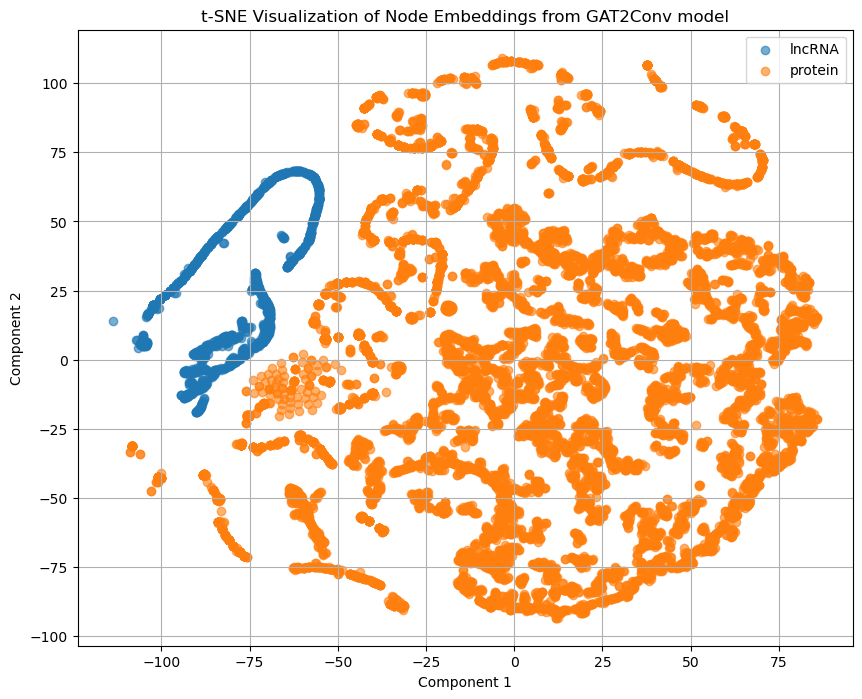

In [14]:
# Plot with color per node type
plt.figure(figsize=(10, 8))
for node_type in np.unique(all_labels):
    idx = all_labels == node_type
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=node_type, alpha=0.6)

plt.legend()
plt.title("t-SNE Visualization of Node Embeddings from GAT2Conv model")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()